In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
from typing import List
import os
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms, utils
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
import torch.nn.functional as F

## Utils

Add util functions below when needed

In [2]:
class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='binary'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(10, 5))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


def plot_test_images_with_labels(X_test, y_test, predictions, num_images=10, index=0):
    """
    Plots test images with their true and predicted labels.
    
    Parameters:
    - X_test: Array of test images.
    - y_test: Array of true labels for the test images.
    - predictions: Array of predicted labels for the test images.
    - num_images: Number of images to plot. Default is 10.
    """
    # Ensure num_images doesn't exceed the number of test images
    num_images = min(num_images, len(X_test))
    
    # Create a figure with a grid of subplots
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Get the image, true label, and predicted label
        img = X_test[i+index]
        true_label = 'War related' if y_test[i+index] == 1 else 'Non war related'
        predicted_label = 'War related' if predictions[i+index] == 1 else 'Non war related'
        # Add subplot
        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    


# Function to visualise class imbalance over batchers
def visualise_dataloader(dl):
    total_num_images = len(dl.dataset)
    class_0_batch_counts = []
    class_1_batch_counts = []

    graph_df = pd.DataFrame({
        'batch_num':[],
        'class_0':[],
        'class_1':[]
    })

    for i, batch in enumerate(dl):
        
        labels = batch[1].tolist()
        unique_labels = set(labels)
        if len(unique_labels) > 2:
            raise ValueError("More than two classes detected")
        
        class_0_count = labels.count(0)
        class_1_count = labels.count(1)

        class_0_batch_counts.append(class_0_count)
        class_1_batch_counts.append(class_1_count)
        
        graph_df.loc[len(graph_df)] = [i+1, class_0_count, class_1_count]
    
    plt.figure(figsize=(10, 6))

    # Bar width
    bar_width = 0.35

    # Plotting bars for class_1
    plt.bar(graph_df['batch_num'], graph_df['class_1'], bar_width, label='Class 1')

    # Plotting bars for class_0
    plt.bar(graph_df['batch_num'] + bar_width, graph_df['class_0'], bar_width, label='Class 0')

    # Adding labels and title
    plt.xlabel('Batch Number')
    plt.ylabel('Number of Images')
    plt.title('Number of Class 1 and Class 0 for Each Batch Number')
    plt.legend()

    plt.tight_layout()
    plt.show()        

In [3]:
# Load labels
df = pd.read_csv("data/new_labels.csv")
df['choice'].value_counts()

choice
not_war                          5692
low_confidence_war                690
military                          571
damaged_infrastructure            207
military&anchor                   202
damaged_infrastructure&anchor      65
Name: count, dtype: int64

In [4]:
# Print total number of images
print(f'Total number of labelled images: {len(df)}')

Total number of labelled images: 7427


In [5]:
# Convert to war not war and visualise class imbalance
df = df[df['choice'] != 'low_confidence_war']

label_mapping = {
    'not_war': 'not_war',
    'military': 'war',
    'damaged_infrastructure': 'war',
    'military&anchor': 'war',
    'damaged_infrastructure&anchor': 'war'
}

df['choice'] = df['choice'].map(label_mapping)

class_counts = df['choice'].value_counts()
class_counts

choice
not_war    5692
war        1045
Name: count, dtype: int64

### Create DataSet class

In [6]:
df['choice'].value_counts()

choice
not_war    5692
war        1045
Name: count, dtype: int64

In [7]:
class WarDataset(Dataset):

    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(labels_file)
        self.transform = transform
        
        # Remove low_confidence_war from data
        self.img_labels = self.img_labels[self.img_labels['choice'] != 'low_confidence_war']


    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 3]
        
        # Convert tensor to PIL image
        image = to_pil_image(image)
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
            
        # Adjust label according to our current schema
        label_mapping = {
            'not_war': 0,
            'military': 1,
            'damaged_infrastructure': 1,
            'military&anchor': 1,
            'damaged_infrastructure&anchor': 1
        }
        
        if label in label_mapping:
            label = label_mapping[label]

        
        return image, label


    def __len__(self):
        return len(self.img_labels)


### Create DataLoader

In [8]:
# Define transform to reshape image to 256x256 and normalise to ImageNet standards
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Initialize the dataset
img_dir = 'data/labelled_images'
labels_file = 'data/new_labels.csv'
dataset = WarDataset(img_dir, labels_file, transform=transform)


# Define the sizes for training, validation, and testing sets
train_size = int(0.7 * len(dataset)) 
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size  

# Split dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Extract train labels from dataset object and calculate sample weights
train_label_list = []
for i in train_dataset:
    label = i[1]
    train_label_list.append(label)
    
train_labels = pd.DataFrame({'labels': train_label_list})
class_counts = train_labels['labels'].value_counts()
sample_weights = [1/class_counts[i] for i in train_labels['labels'].values]

# Create sampler for the train to fix class imbalance - note sample weights calculated above
sampler = WeightedRandomSampler(weights=sample_weights, num_samples = len(train_dataset), replacement=True)

# Create a DataLoader
train_loader = DataLoader(train_dataset, sampler = sampler, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

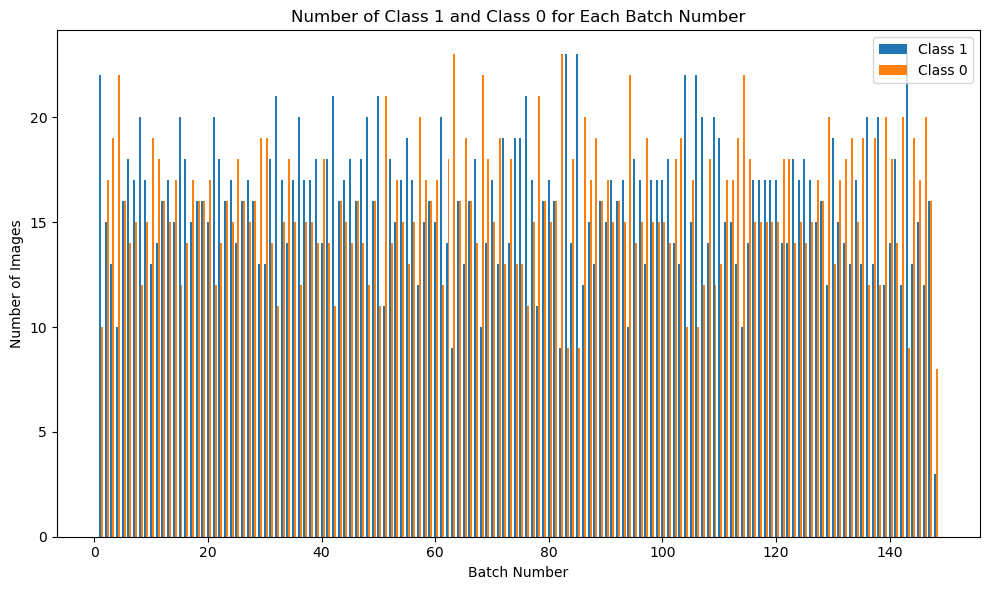

In [9]:
# Observe label distribution for train_loader and test_loader
visualise_dataloader(train_loader)

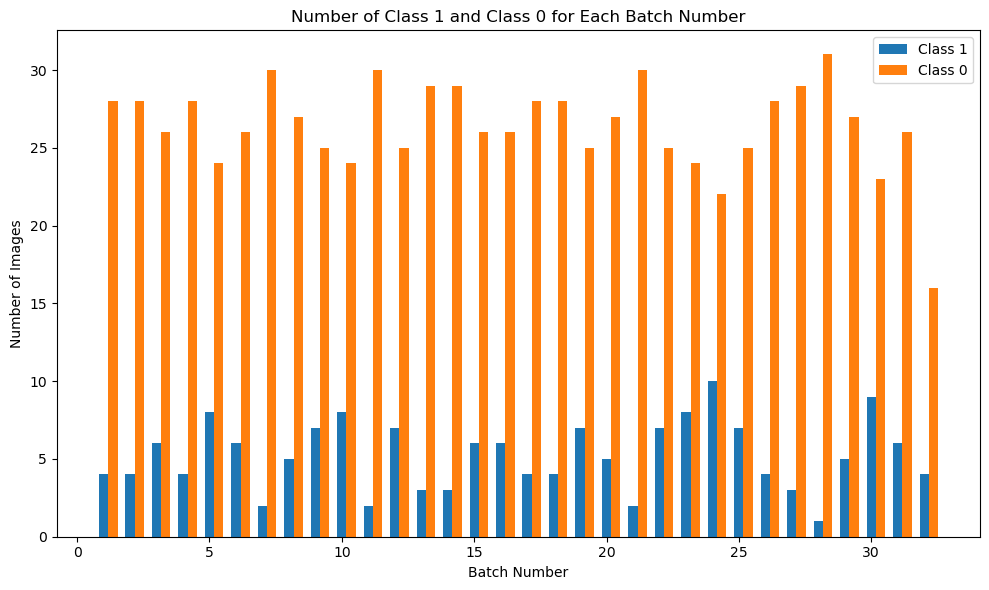

In [61]:
visualise_dataloader(test_loader)

Display image from a batch from the dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 256, 256])
tensor(1)


<function matplotlib.pyplot.show(close=None, block=None)>

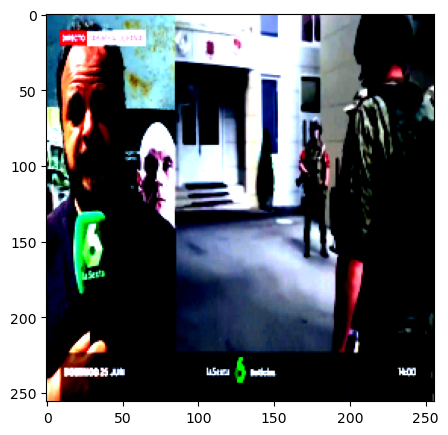

In [63]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0].permute(1, 2, 0).numpy()  # Permute to (height, width, channels) and convert to numpy
label = train_labels[0]

print(label)
plt.figure(figsize=(5, 10))
plt.imshow(img)
plt.show

## Model Training

TO DO: Try to add focal crossentropy loss function

TO DO: Check the model architecture - is the output layer correctly specificed?

In [8]:
resnet50 = torchvision.models.resnet50(weights='IMAGENET1K_V1')

# Freeze params of pre-trained model
for param in resnet50.parameters():
    param.requires_grad = False
    
# Get the number of input features for the custom head
num_ftrs = resnet50.fc.in_features

# Define the custom head with two additional dense layers
resnet50.fc = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU()
)

# Move the model to GPU if available
# Windows
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet50.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)


print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

TO DO: Figure out how to add early stopping to the model!

In [9]:
# Define a function to train the model
def train_model(model, dataloader, criterion, optimizer, num_epochs=10, patience=3):
    best_loss = float('inf')
    patience_counter= 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), torch.tensor(labels).to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss.item() * inputs.size(0)
            loop.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad(): # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()*inputs.size(0)
                
        val_loss /= len(val_loader.dataset)
        print(f'Validation Loss: {val_loss:.4f}')
        
        # Check for early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'model_weights/ResNet_best_model_training.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping')
                model.load_state_dict(torch.load('model_weights/ResNet_best_model_training.pth'))
                return model
    
    print('Training complete')
    model.load_state_dict(torch.load('model_weights/ResNet_best_model_training.pth'))  # Load the best model at the end
    
    return model

In [10]:
# Train the model
trained_model = train_model(resnet50, train_loader, criterion, optimizer, num_epochs=10, patience=3)

Epoch 1/10:   0%|          | 0/148 [00:00<?, ?batch/s]C:\Users\gatla\AppData\Local\Temp\ipykernel_52764\540585815.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels).to(device)
Epoch 1/10: 100%|██████████| 148/148 [06:55<00:00,  2.81s/batch, loss=0.177]


Epoch [1/10], Loss: 0.4494
Validation Loss: 0.2789


Epoch 2/10: 100%|██████████| 148/148 [07:15<00:00,  2.94s/batch, loss=0.198]


Epoch [2/10], Loss: 0.2705
Validation Loss: 0.1731


Epoch 3/10: 100%|██████████| 148/148 [07:15<00:00,  2.94s/batch, loss=0.104]


Epoch [3/10], Loss: 0.2547
Validation Loss: 0.2892


Epoch 4/10: 100%|██████████| 148/148 [07:08<00:00,  2.90s/batch, loss=0.275] 


Epoch [4/10], Loss: 0.2768
Validation Loss: 0.1733


Epoch 5/10: 100%|██████████| 148/148 [07:08<00:00,  2.90s/batch, loss=0.0532]


Epoch [5/10], Loss: 0.2365
Validation Loss: 0.4062
Early stopping


### Model evaluation

In [11]:
# Convert images back to standard size
def denormalize(image_numpy, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    image_numpy = (image_numpy * std + mean)
    return image_numpy

def reverse_transform(image_numpy):
    # Define mean and std used for normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # Denormalize
    image_numpy = denormalize(image_numpy, mean, std)
    
    # Clip the values to be in the range [0, 1]
    image_numpy = np.clip(image_numpy, 0, 1)
    
    # Convert to PIL image
    #'image_pil = Image.fromarray((image_numpy * 255).astype(np.uint8))
    
    return image_numpy

Note images are not re-sized in the following function as there is no way to undo a stadard resizing.

QUESTION: Why is there a softmax in the below? Should the softmax not be part of the model itself rather than in the eval function?

In [24]:
def evaluate_model_with_images(model, dataloader, threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    all_images = []
    all_probs = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)  # Get probabilities for each class
            
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilities of the positive class
            
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(inputs.cpu().numpy())
    
    # Reverse transformations for all images
    denormalized_images = [reverse_transform(image.transpose(1, 2, 0)) for image in all_images]
    
    return denormalized_images, all_labels, all_probs

In [32]:
all_images, all_labels, all_probs = evaluate_model_with_images(trained_model, test_loader)

Evaluating: 100%|██████████| 32/32 [02:07<00:00,  3.98s/batch]


Binary threshold selection based on maximisng F1 score

In [34]:
# Initialize variables to store the best F1 score and the corresponding threshold
best_f1 = 0
best_threshold = 0

# Iterate over possible thresholds from 0 to 1 with a step size
thresholds = np.arange(0, 1.01, 0.01)

for threshold in thresholds:
    # Generate predictions based on the current threshold
    predictions = [1 if prob >= threshold else 0 for prob in all_probs]
    
    # Calculate the F1 score
    f1 = f1_score(all_labels, predictions)
    
    # Update the best F1 score and threshold if the current F1 score is higher
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Print the best threshold and the corresponding F1 score
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1}")

# Generate final predictions based on optimal threshold
all_preds = [1 if prob >= best_threshold else 0 for prob in all_probs]

Best Threshold: 0.37
Best F1 Score: 0.8047337278106508


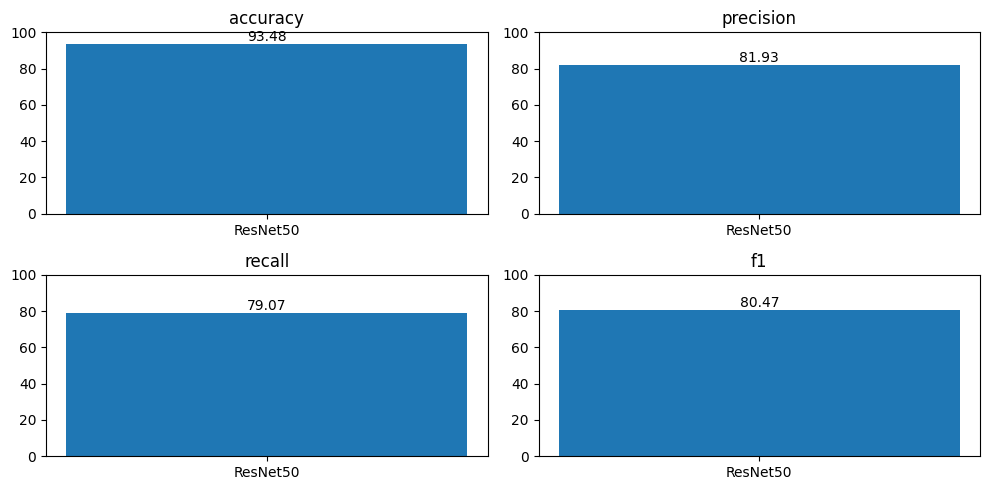

In [35]:
metrics = Metrics()
metrics.run(all_labels, all_preds, "ResNet50")
metrics.plot()

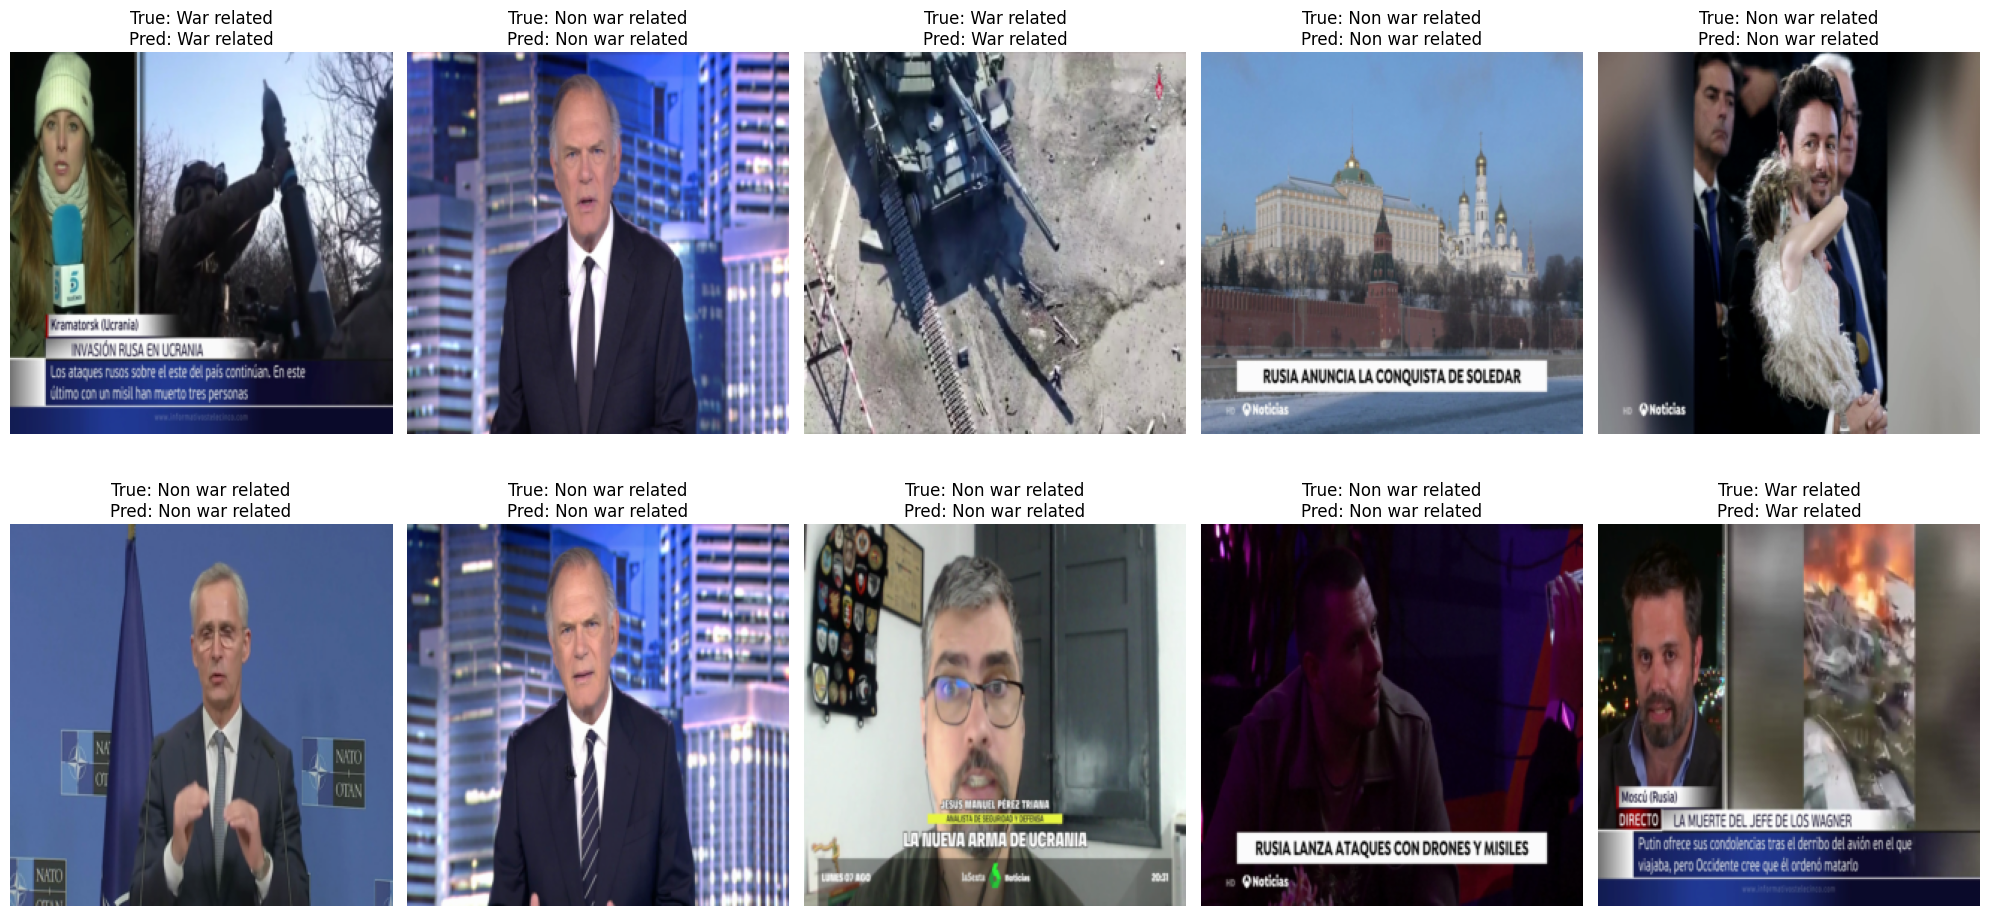

In [36]:
plot_test_images_with_labels(all_images, all_labels, all_preds, num_images=10, index=50)

### Save model weights

In [ ]:
# Save ResNet50 model weights
torch.save(resnet50.state_dict(), 'model_weights/resnet50_custom_head.pth')